**Modelo RF para evaluar distinción de sinteticos/reales, con agrupación de diagnosticos/tratamientos**

In [8]:
import pandas as pd
import numpy as np
import os
import base64
from collections import Counter
from datetime import datetime, timedelta
from random import choices, randint
from faker import Faker
import time
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

fake = Faker()

# Definición de parámetros
frequency_values = [0.0005]
k_values = [20, 50, 100]
n_values = [10, 100, 200]
results = []

# Funciones auxiliares
def generate_base64_id():
    random_bytes = os.urandom(9)
    base64_id = base64.b64encode(random_bytes).decode('utf-8').rstrip('=')
    return base64_id

def get_value_from_distribution(distribution):
    population = list(distribution.keys())
    weights = list(distribution.values())
    return choices(population, weights, k=1)[0]

def assign_diagnoses_or_procedures(distribution, max_assignments):
    assigned_values = []
    if 'missing' in distribution:
        missing_probability = distribution['missing']
        if np.random.rand() < missing_probability:
            assigned_values = [np.nan] * max_assignments
        else:
            non_missing_distribution = {key: distribution[key] for key in distribution if key != 'missing'}
            num_assignments = max(1, int((1 - missing_probability) * max_assignments))
            assigned_values = choices(
                list(non_missing_distribution.keys()),
                weights=list(non_missing_distribution.values()),
                k=num_assignments
            )
    else:
        non_missing_distribution = distribution
        num_assignments = max_assignments
        assigned_values = choices(
            list(non_missing_distribution.keys()),
            weights=list(non_missing_distribution.values()),
            k=num_assignments
        )
    assigned_values.sort(key=lambda x: non_missing_distribution.get(x, 0), reverse=True)
    assigned_values += [np.nan] * (max_assignments - len(assigned_values))
    return assigned_values

def process_diagnosis_for_poa(diagnosis):
    if isinstance(diagnosis, str):
        if diagnosis.endswith('-S'):
            return diagnosis[:-2], 'S'
        elif diagnosis.endswith('-N'):
            return diagnosis[:-2], 'N'
        elif diagnosis.endswith('-D'):
            return diagnosis[:-2], 'D'
        elif diagnosis.endswith('-I'):
            return diagnosis[:-2], 'I'
        elif diagnosis.endswith('-E'):
            return diagnosis[:-2], 'E'
        return diagnosis, ""
    else:
        return np.nan, np.nan

def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    if diagnosis_type == 'DP':
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        diagnosis, poa = process_diagnosis_for_poa(diagnosis_main[0])
        return diagnosis, poa
    else:
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        missing_secondary_probability = metrics.get('top_n_diagnoses_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            secondary_diagnoses = [np.nan] * 14
        diagnoses_with_poa = [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]
        return diagnoses_with_poa

def assign_treatments_with_missing(metrics, treatment_type='PP'):
    if treatment_type == 'PP':
        treatment_main = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)
        return treatment_main[0]
    else:
        treatments_secondary = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)
        missing_secondary_probability = metrics.get('top_n_treatments_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            treatments_secondary = [np.nan] * 14
        return treatments_secondary

def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()
    if col_range > 400:
        num_bins = 1000
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()
    return binned_distribution

def calculate_missing_metrics(df, columns):
    df = df.copy()  # Evitar SettingWithCopyWarning
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

def generate_synthetic_episodes(cluster_id, num_episodes, metrics):
    episodes = []
    for _ in range(num_episodes):
        patient_id = generate_base64_id()
        patient_episodes = int(get_value_from_distribution(metrics['episode_distribution']))
        for _ in range(patient_episodes):
            edad_bin = get_value_from_distribution(metrics['Edat'])
            if isinstance(edad_bin, pd.Interval):
                edad = randint(int(edad_bin.left), int(edad_bin.right))
            else:
                edad = int(edad_bin)

            dies_estada_bin = get_value_from_distribution(metrics['Dies_estada'])
            if isinstance(dies_estada_bin, pd.Interval):
                dies_estada = randint(int(dies_estada_bin.left), int(dies_estada_bin.right))
            else:
                dies_estada = int(dies_estada_bin)
            dies_estada = max(0, dies_estada)

            DRG_bin = get_value_from_distribution(metrics['DRG'])
            if isinstance(DRG_bin, pd.Interval):
                DRG = randint(int(DRG_bin.left), int(DRG_bin.right))
            else:
                DRG = int(DRG_bin)

            current_year = datetime.now().year
            birth_year = current_year - edad
            birth_month_day = fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%m-%d')
            data_naix = f'{birth_year}-{birth_month_day} 0:00'

            data_ingres = fake.date_time_this_decade(before_now=True, after_now=False)
            data_alta = data_ingres + timedelta(days=dies_estada)

            data_ingres_str = data_ingres.strftime('%d/%m/%Y %H:%M')
            data_alta_str = data_alta.strftime('%d/%m/%Y %H:%M')

            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='other_diagnoses')

            DS_list = [f'DS{i+1}' for i in range(14)]
            POA_list = [f'POA{i+1}' for i in range(14)]

            diagnosis_secondary_dict = {DS_list[i]: diag[0] for i, diag in enumerate(secondary_diagnoses_with_poa)}
            poa_secondary_dict = {POA_list[i]: diag[1] for i, diag in enumerate(secondary_diagnoses_with_poa)}

            PP = assign_treatments_with_missing(metrics, treatment_type='PP')
            secondary_treatments = assign_treatments_with_missing(metrics, treatment_type='other_treatments')

            PS_list = [f'PS{i+1}' for i in range(14)]
            procedures_secondary_dict = {PS_list[i]: secondary_treatments[i] for i in range(14)}

            record = {
                "Id_pacient": patient_id,
                "Data_naix": data_naix,
                "Edat": edad,
                "Sexe": get_value_from_distribution(metrics['Sexe']),
                "Data_ingres": data_ingres_str,
                "Circ_admiss": get_value_from_distribution(metrics['Circ_admiss']),
                "Procedencia ingres": get_value_from_distribution(metrics['Procedencia ingres']),
                "Data_alta": data_alta_str,
                "Circ_alta": get_value_from_distribution(metrics['Circ_alta']),
                "Dies_estada": dies_estada,
                "Servei_alta": get_value_from_distribution(metrics['Servei_alta']),
                "Descr_Servei-alta": get_value_from_distribution(metrics['Descr_Servei-alta']),
                "DRG": DRG,
                "T. asist.": get_value_from_distribution(metrics['T. asist.']),
                "DP": DP, "PP": PP, "POAP": POAP, **diagnosis_secondary_dict,  **procedures_secondary_dict, **poa_secondary_dict,
                "cluster": cluster_id
            }
            episodes.append(record)
    return episodes

# Inicio del bucle principal
for frequency in frequency_values:
    start_time = time.time()
    # Cargar y procesar los datos
    df = pd.read_csv('scrambled-CMBDAH 2021-23 episodes.csv', sep=';', low_memory=False)
    df['Data_naix'] = pd.to_datetime(df['Data_naix'], dayfirst=True).dt.date
    df['Id_pacient'] = df.groupby(['Data_naix', 'Sexe'])['Id_pacient'].transform('first')
    output_path_modified = 'modified_CMBDAH_2021_23_episodes.csv'
    df.to_csv(output_path_modified,  sep=';', index=False)

    # Modificar diagnósticos y tratamientos
    df['DP'] = df.apply(lambda row: f"{row['DP']}-S" if row['POAP'] == 'S' else (f"{row['DP']}-N" if row['POAP'] == 'N' else None), axis=1)
    for i in range(1, 15):
        df[f'DS{i}'] = df.apply(lambda row: f"{row[f'DS{i}']}-S" if row[f'POA{i}'] == 'S' else (f"{row[f'DS{i}']}-N" if row[f'POA{i}'] == 'N' else None), axis=1)

    df['other_diagnostics'] = df[[f'DS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_diagnostics = df.groupby('Id_pacient').agg({
        'DP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_diagnostics': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_diagnostics = [diag for sublist in df_grouped_diagnostics['other_diagnostics'] for diag in sublist] + df_grouped_diagnostics['DP'].dropna().tolist()
    diagnostic_counts = pd.Series(all_diagnostics).value_counts(normalize=True)
    significant_diagnostics = diagnostic_counts[diagnostic_counts > frequency].index

    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x in significant_diagnostics else None)
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: [diag for diag in x if diag in significant_diagnostics])
    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if len(x) > 0 else ['No_Diagnosis'])

    df['PP'] = df['PP'].apply(lambda x: x if pd.notnull(x) else None)
    df['other_treatments'] = df[[f'PS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_treatments = df.groupby('Id_pacient').agg({
        'PP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_treatments': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_treatments = [treat for sublist in df_grouped_treatments['other_treatments'] for treat in sublist] + df_grouped_treatments['PP'].dropna().tolist()
    treatment_counts = pd.Series(all_treatments).value_counts(normalize=True)
    significant_treatments = treatment_counts[treatment_counts > frequency].index

    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x in significant_treatments else None)
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: [treat for treat in x if treat in significant_treatments])
    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if len(x) > 0 else ['No_Treatment'])

    # Asegurarse de que no hay valores None o listas vacías
    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x else ['Unknown'])
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if x else ['Unknown'])

    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x else ['Unknown'])
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if x else ['Unknown'])

    # Aplicar MultiLabelBinarizer
    mlb_diagnostics = MultiLabelBinarizer()
    diagnostics_encoded = mlb_diagnostics.fit_transform(df_grouped_diagnostics['DP'] + df_grouped_diagnostics['other_diagnostics'])
    diagnostics_df = pd.DataFrame(diagnostics_encoded, columns=mlb_diagnostics.classes_)

    mlb_treatments = MultiLabelBinarizer()
    treatments_encoded = mlb_treatments.fit_transform(df_grouped_treatments['PP'] + df_grouped_treatments['other_treatments'])
    treatments_df = pd.DataFrame(treatments_encoded, columns=mlb_treatments.classes_)

    df_combined = pd.concat([df_grouped_diagnostics['Id_pacient'], diagnostics_df, treatments_df], axis=1)
    output_path = 'final_ohe_patients.csv'
    df_combined.to_csv(output_path, sep=';', index=False)

    diagnostics_encoded = diagnostics_df.values.astype(np.float64)
    treatments_encoded = treatments_df.values.astype(np.float64)
    X_clustering = np.hstack((diagnostics_encoded, treatments_encoded))

    for k in k_values:
        # Clustering
        import CoreFunctions as cf

        print(f"Combinación actual: frequency = {frequency}, k = {k}")
        print("Muestra de X_clustering antes del clustering:")
        print(X_clustering[:5])
        print(f"Tipo de datos de X_clustering: {X_clustering.dtype}")

        if X_clustering.dtype == 'O':
            X_clustering = X_clustering.astype(np.float64)
            print("Se ha convertido X_clustering a tipo float64.")

        M, P, CL = cf.NaiveBayesClustering(X_clustering, k)

        if len(CL) == len(df_combined):
            df_combined['cluster'] = CL
        else:
            raise ValueError("La longitud del vector de clusters no coincide con el número de pacientes agrupados.")

        df_cluster = df.merge(df_combined[['Id_pacient', 'cluster']], on='Id_pacient', how='left')
        df_cluster.to_csv(f'data_cluster_k{k}.csv', sep=';', index=False)

        clusters = df_cluster['cluster'].unique()
        cluster_frequencies = df_cluster['cluster'].value_counts(normalize=True)

        # Aquí iniciamos el bucle sobre n_values
        for n in n_values:
            cluster_metrics = {}

            def get_top_n_diagnoses_with_poa_suffix_v2(df_subset, diagnosis_columns, poa_columns, n, separate_DP=False):
                df_subset = df_subset.copy()
                count_series_secondary = pd.Series(dtype=int)
                count_series_DP = pd.Series(dtype=int)
                missing_count_DP = 0
                missing_count_secondary = 0
                total_count_DP = 0
                total_count_secondary = 0
                poa_suffix_map = {
                    'S': '-S',
                    'N': '-N',
                    'D': '-D',
                    'I': '-I',
                    'E': '-E'
                }
                if separate_DP:
                    df_subset.loc[:, 'DP'] = df_subset.apply(lambda row: f"{row['DP']}{poa_suffix_map.get(row['POAP'], '')}" if pd.notnull(row['DP']) and row['DP'] != '' else None, axis=1)
                    count_series_DP = df_subset['DP'].value_counts()
                    total_count_DP = len(df_subset['DP'])
                    missing_count_DP = df_subset['DP'].isnull().sum() + (df_subset['DP'] == '').sum()
                    diagnosis_columns = diagnosis_columns[1:]
                    poa_columns = poa_columns[1:]
                for diag_col, poa_col in zip(diagnosis_columns, poa_columns):
                    df_subset.loc[:, diag_col] = df_subset.apply(lambda row: f"{row[diag_col]}{poa_suffix_map.get(row[poa_col], '')}" if pd.notnull(row[diag_col]) and row[diag_col] != '' else None, axis=1)
                    missing_count_secondary += df_subset[diag_col].isnull().sum() + (df_subset[diag_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df_subset[diag_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df_subset[diag_col])
                dp_top_n = count_series_DP.nlargest(n)
                dp_top_n_rel = dp_top_n / dp_top_n.sum() if dp_top_n.sum() > 0 else dp_top_n
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum() if secondary_top_n.sum() > 0 else secondary_top_n
                missing_proportion_DP = missing_count_DP / total_count_DP if total_count_DP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'DP': dp_top_n_rel.to_dict(),
                    'other_diagnoses': secondary_top_n_rel.to_dict(),
                    'missing_DP': missing_proportion_DP,
                    'missing_secondary': calculate_missing_metrics(df_subset, diagnosis_columns)
                }
                return results

            def get_top_n_treatments_with_missing_v2(df_subset, treatment_columns, n, separate_PP=False):
                df_subset = df_subset.copy()
                count_series_secondary = pd.Series(dtype=int)
                count_series_PP = pd.Series(dtype=int)
                missing_count_PP = 0
                missing_count_secondary = 0
                total_count_PP = 0
                total_count_secondary = 0
                if separate_PP:
                    count_series_PP = df_subset['PP'].value_counts()
                    total_count_PP = len(df_subset['PP'])
                    missing_count_PP = df_subset['PP'].isnull().sum() + (df_subset['PP'] == '').sum()
                    treatment_columns = treatment_columns[1:]
                for treatment_col in treatment_columns:
                    missing_count_secondary += df_subset[treatment_col].isnull().sum() + (df_subset[treatment_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df_subset[treatment_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df_subset[treatment_col])
                pp_top_n = count_series_PP.nlargest(n)
                pp_top_n_rel = pp_top_n / pp_top_n.sum() if pp_top_n.sum() > 0 else pp_top_n
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum() if secondary_top_n.sum() > 0 else secondary_top_n
                missing_proportion_PP = missing_count_PP / total_count_PP if total_count_PP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'PP': pp_top_n_rel.to_dict(),
                    'other_treatments': secondary_top_n_rel.to_dict(),
                    'missing_PP': missing_proportion_PP,
                    'missing_secondary': calculate_missing_metrics(df_subset, treatment_columns)
                }
                return results

            # Cálculo de métricas por cluster con el n actual
            for cluster_id in clusters:
                cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
                metrics = {'frecuencia_cluster': cluster_frequencies[cluster_id]}
                categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta', 'Descr_Servei-alta', 'T. asist.']
                continuous_vars = ['Edat', 'Dies_estada', 'DRG']
                episode_counts = cluster_data['Id_pacient'].value_counts()
                metrics['episode_distribution'] = episode_counts.value_counts(normalize=True).to_dict()
                for var in categorical_vars:
                    metrics[var] = cluster_data[var].value_counts(normalize=True, dropna=False).to_dict()
                for var in continuous_vars:
                    metrics[var] = get_custom_binned_distribution(cluster_data, var)
                metrics['top_n_diagnoses_separated'] = get_top_n_diagnoses_with_poa_suffix_v2(
                    cluster_data,
                    ['DP'] + [f'DS{i}' for i in range(1, 15)],
                    ['POAP'] + [f'POA{i}' for i in range(1, 15)],
                    n=n, separate_DP=True
                )
                metrics['top_n_treatments_separated'] = get_top_n_treatments_with_missing_v2(
                    cluster_data,
                    ['PP'] + [f'PS{i}' for i in range(1, 15)],
                    n=n, separate_PP=True
                )
                cluster_metrics[cluster_id] = metrics

            # Generación de episodios sintéticos
            total_patients = 60000
            episodes = []
            for cluster_id, metrics in cluster_metrics.items():
                cluster_frequency = metrics['frecuencia_cluster']
                num_episodes = int(cluster_frequency * total_patients)
                episodes += generate_synthetic_episodes(cluster_id, num_episodes, metrics)
            df_episodes = pd.DataFrame(episodes)
            df_episodes.to_csv(f'episodios_sinteticos_k{k}_n{n}_freq{frequency}.csv', sep=';', index=False)

            # Evaluación del modelo
            synthetic_sample = df_episodes.sample(n=1000, random_state=47).copy()
            synthetic_sample['source'] = 'synthetic'
            real_sample = df_cluster.sample(n=1000, random_state=49).copy()
            real_sample['source'] = 'real'

            # Preparar los datos para el modelo RandomForest
            common_columns = synthetic_sample.columns.intersection(real_sample.columns)
            synthetic_sample = synthetic_sample[common_columns]
            real_sample = real_sample[common_columns]

            diagnosis_columns = [f'DS{i}' for i in range(1, 15)]
            treatment_columns = [f'PS{i}' for i in range(1, 15)]

            synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

            synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_treatments'] = real_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

            synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
            real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

            poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
            synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
            real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

            combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)
            combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

            combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')
            combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

            combined_data.fillna(-1, inplace=True)

            encoded_data = pd.get_dummies(combined_data)

            # Usamos 'X_eval' y 'y_eval' para evitar sobrescribir 'X'
            X_eval = encoded_data.drop(columns=['is_real'])
            y_eval = encoded_data['is_real']

            X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=0.3, random_state=42)
            model = RandomForestClassifier(random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            report = classification_report(y_test, y_pred, output_dict=True)
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1_score = report['weighted avg']['f1-score']
            accuracy = report['accuracy']
            end_time = time.time()
            execution_time = end_time - start_time
            results.append({
                'frequency': frequency,
                'k': k,
                'n': n,
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'accuracy': accuracy,
                'execution_time': execution_time
            })

# Encontrar el mejor resultado
results_df = pd.DataFrame(results)
best_iteration = results_df.loc[results_df['f1_score'].idxmax()]
best_frequency = best_iteration['frequency']
best_k = best_iteration['k']
best_n = best_iteration['n']

print("Mejores parámetros encontrados:")
print(f"Frequency: {best_frequency}, k: {best_k}, n: {best_n}")
print(f"F1-Score: {best_iteration['f1_score']}, Precision: {best_iteration['precision']}, Recall: {best_iteration['recall']}")
print(f"Tiempo de ejecución: {best_iteration['execution_time']} segundos")

# Mostrar el DataFrame de resultados con tiempos de ejecución
print("\nResultados completos:")
print(results_df)

# Cargar el mejor archivo y graficar (opcional)
# df_best = pd.read_csv(f'episodios_sinteticos_k{best_k}_n{best_n}_freq{best_frequency}.csv', sep=';')



Combinación actual: frequency = 0.0005, k = 20
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Combinación actual: frequency = 0.0005, k = 50
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Combinación actual: frequency = 0.0005, k = 100
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Mejores parámetros encontrados:
Frequency: 0.0005, k: 20.0, n: 10.0
F1-Score: 0.8932384510466702, Precision: 0.8951353762433651, Recall: 0.8933333333333333
Tiempo de ejecución: 91.58828830718994 segundos

Resultados completos

In [7]:
import pandas as pd
import numpy as np
import os
import base64
from collections import Counter
from datetime import datetime, timedelta
from random import choices, randint
from faker import Faker
import time
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

fake = Faker()

# Definición de parámetros
frequency_values = [0.0001]
k_values = [150, 200]
n_values = [50, 200]
results = []

# Funciones auxiliares
def generate_base64_id():
    random_bytes = os.urandom(9)
    base64_id = base64.b64encode(random_bytes).decode('utf-8').rstrip('=')
    return base64_id

def get_value_from_distribution(distribution):
    population = list(distribution.keys())
    weights = list(distribution.values())
    return choices(population, weights, k=1)[0]

def assign_diagnoses_or_procedures(distribution, max_assignments):
    assigned_values = []
    if 'missing' in distribution:
        missing_probability = distribution['missing']
        if np.random.rand() < missing_probability:
            assigned_values = [np.nan] * max_assignments
        else:
            non_missing_distribution = {key: distribution[key] for key in distribution if key != 'missing'}
            num_assignments = max(1, int((1 - missing_probability) * max_assignments))
            assigned_values = choices(
                list(non_missing_distribution.keys()),
                weights=list(non_missing_distribution.values()),
                k=num_assignments
            )
    else:
        non_missing_distribution = distribution
        num_assignments = max_assignments
        assigned_values = choices(
            list(non_missing_distribution.keys()),
            weights=list(non_missing_distribution.values()),
            k=num_assignments
        )
    assigned_values.sort(key=lambda x: non_missing_distribution.get(x, 0), reverse=True)
    assigned_values += [np.nan] * (max_assignments - len(assigned_values))
    return assigned_values

def process_diagnosis_for_poa(diagnosis):
    if isinstance(diagnosis, str):
        if diagnosis.endswith('-S'):
            return diagnosis[:-2], 'S'
        elif diagnosis.endswith('-N'):
            return diagnosis[:-2], 'N'
        elif diagnosis.endswith('-D'):
            return diagnosis[:-2], 'D'
        elif diagnosis.endswith('-I'):
            return diagnosis[:-2], 'I'
        elif diagnosis.endswith('-E'):
            return diagnosis[:-2], 'E'
        return diagnosis, ""
    else:
        return np.nan, np.nan

def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    if diagnosis_type == 'DP':
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        diagnosis, poa = process_diagnosis_for_poa(diagnosis_main[0])
        return diagnosis, poa
    else:
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        missing_secondary_probability = metrics.get('top_n_diagnoses_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            secondary_diagnoses = [np.nan] * 14
        diagnoses_with_poa = [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]
        return diagnoses_with_poa

def assign_treatments_with_missing(metrics, treatment_type='PP'):
    if treatment_type == 'PP':
        treatment_main = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)
        return treatment_main[0]
    else:
        treatments_secondary = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)
        missing_secondary_probability = metrics.get('top_n_treatments_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            treatments_secondary = [np.nan] * 14
        return treatments_secondary

def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()
    if col_range > 400:
        num_bins = 1000
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()
    return binned_distribution

def calculate_missing_metrics(df, columns):
    df = df.copy()  # Evitar SettingWithCopyWarning
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

def generate_synthetic_episodes(cluster_id, num_episodes, metrics):
    episodes = []
    for _ in range(num_episodes):
        patient_id = generate_base64_id()
        patient_episodes = int(get_value_from_distribution(metrics['episode_distribution']))
        for _ in range(patient_episodes):
            edad_bin = get_value_from_distribution(metrics['Edat'])
            if isinstance(edad_bin, pd.Interval):
                edad = randint(int(edad_bin.left), int(edad_bin.right))
            else:
                edad = int(edad_bin)

            dies_estada_bin = get_value_from_distribution(metrics['Dies_estada'])
            if isinstance(dies_estada_bin, pd.Interval):
                dies_estada = randint(int(dies_estada_bin.left), int(dies_estada_bin.right))
            else:
                dies_estada = int(dies_estada_bin)
            dies_estada = max(0, dies_estada)

            DRG_bin = get_value_from_distribution(metrics['DRG'])
            if isinstance(DRG_bin, pd.Interval):
                DRG = randint(int(DRG_bin.left), int(DRG_bin.right))
            else:
                DRG = int(DRG_bin)

            current_year = datetime.now().year
            birth_year = current_year - edad
            birth_month_day = fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%m-%d')
            data_naix = f'{birth_year}-{birth_month_day} 0:00'

            data_ingres = fake.date_time_this_decade(before_now=True, after_now=False)
            data_alta = data_ingres + timedelta(days=dies_estada)

            data_ingres_str = data_ingres.strftime('%d/%m/%Y %H:%M')
            data_alta_str = data_alta.strftime('%d/%m/%Y %H:%M')

            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='other_diagnoses')

            DS_list = [f'DS{i+1}' for i in range(14)]
            POA_list = [f'POA{i+1}' for i in range(14)]

            diagnosis_secondary_dict = {DS_list[i]: diag[0] for i, diag in enumerate(secondary_diagnoses_with_poa)}
            poa_secondary_dict = {POA_list[i]: diag[1] for i, diag in enumerate(secondary_diagnoses_with_poa)}

            PP = assign_treatments_with_missing(metrics, treatment_type='PP')
            secondary_treatments = assign_treatments_with_missing(metrics, treatment_type='other_treatments')

            PS_list = [f'PS{i+1}' for i in range(14)]
            procedures_secondary_dict = {PS_list[i]: secondary_treatments[i] for i in range(14)}

            record = {
                "Id_pacient": patient_id,
                "Data_naix": data_naix,
                "Edat": edad,
                "Sexe": get_value_from_distribution(metrics['Sexe']),
                "Data_ingres": data_ingres_str,
                "Circ_admiss": get_value_from_distribution(metrics['Circ_admiss']),
                "Procedencia ingres": get_value_from_distribution(metrics['Procedencia ingres']),
                "Data_alta": data_alta_str,
                "Circ_alta": get_value_from_distribution(metrics['Circ_alta']),
                "Dies_estada": dies_estada,
                "Servei_alta": get_value_from_distribution(metrics['Servei_alta']),
                "Descr_Servei-alta": get_value_from_distribution(metrics['Descr_Servei-alta']),
                "DRG": DRG,
                "T. asist.": get_value_from_distribution(metrics['T. asist.']),
                "DP": DP, "PP": PP, "POAP": POAP, **diagnosis_secondary_dict,  **procedures_secondary_dict, **poa_secondary_dict,
                "cluster": cluster_id
            }
            episodes.append(record)
    return episodes

# Inicio del bucle principal
for frequency in frequency_values:
    start_time = time.time()
    # Cargar y procesar los datos
    df = pd.read_csv('scrambled-CMBDAH 2021-23 episodes.csv', sep=';', low_memory=False)
    df['Data_naix'] = pd.to_datetime(df['Data_naix'], dayfirst=True).dt.date
    df['Id_pacient'] = df.groupby(['Data_naix', 'Sexe'])['Id_pacient'].transform('first')
    output_path_modified = 'modified_CMBDAH_2021_23_episodes.csv'
    df.to_csv(output_path_modified,  sep=';', index=False)

    # Modificar diagnósticos y tratamientos
    df['DP'] = df.apply(lambda row: f"{row['DP']}-S" if row['POAP'] == 'S' else (f"{row['DP']}-N" if row['POAP'] == 'N' else None), axis=1)
    for i in range(1, 15):
        df[f'DS{i}'] = df.apply(lambda row: f"{row[f'DS{i}']}-S" if row[f'POA{i}'] == 'S' else (f"{row[f'DS{i}']}-N" if row[f'POA{i}'] == 'N' else None), axis=1)

    df['other_diagnostics'] = df[[f'DS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_diagnostics = df.groupby('Id_pacient').agg({
        'DP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_diagnostics': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_diagnostics = [diag for sublist in df_grouped_diagnostics['other_diagnostics'] for diag in sublist] + df_grouped_diagnostics['DP'].dropna().tolist()
    diagnostic_counts = pd.Series(all_diagnostics).value_counts(normalize=True)
    significant_diagnostics = diagnostic_counts[diagnostic_counts > frequency].index

    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x in significant_diagnostics else None)
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: [diag for diag in x if diag in significant_diagnostics])
    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if len(x) > 0 else ['No_Diagnosis'])

    df['PP'] = df['PP'].apply(lambda x: x if pd.notnull(x) else None)
    df['other_treatments'] = df[[f'PS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_treatments = df.groupby('Id_pacient').agg({
        'PP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_treatments': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_treatments = [treat for sublist in df_grouped_treatments['other_treatments'] for treat in sublist] + df_grouped_treatments['PP'].dropna().tolist()
    treatment_counts = pd.Series(all_treatments).value_counts(normalize=True)
    significant_treatments = treatment_counts[treatment_counts > frequency].index

    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x in significant_treatments else None)
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: [treat for treat in x if treat in significant_treatments])
    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if len(x) > 0 else ['No_Treatment'])

    # Asegurarse de que no hay valores None o listas vacías
    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x else ['Unknown'])
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if x else ['Unknown'])

    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x else ['Unknown'])
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if x else ['Unknown'])

    # Aplicar MultiLabelBinarizer
    mlb_diagnostics = MultiLabelBinarizer()
    diagnostics_encoded = mlb_diagnostics.fit_transform(df_grouped_diagnostics['DP'] + df_grouped_diagnostics['other_diagnostics'])
    diagnostics_df = pd.DataFrame(diagnostics_encoded, columns=mlb_diagnostics.classes_)

    mlb_treatments = MultiLabelBinarizer()
    treatments_encoded = mlb_treatments.fit_transform(df_grouped_treatments['PP'] + df_grouped_treatments['other_treatments'])
    treatments_df = pd.DataFrame(treatments_encoded, columns=mlb_treatments.classes_)

    df_combined = pd.concat([df_grouped_diagnostics['Id_pacient'], diagnostics_df, treatments_df], axis=1)
    output_path = 'final_ohe_patients.csv'
    df_combined.to_csv(output_path, sep=';', index=False)

    diagnostics_encoded = diagnostics_df.values.astype(np.float64)
    treatments_encoded = treatments_df.values.astype(np.float64)
    X_clustering = np.hstack((diagnostics_encoded, treatments_encoded))

    for k in k_values:
        # Clustering
        import CoreFunctions as cf

        print(f"Combinación actual: frequency = {frequency}, k = {k}")
        print("Muestra de X_clustering antes del clustering:")
        print(X_clustering[:5])
        print(f"Tipo de datos de X_clustering: {X_clustering.dtype}")

        if X_clustering.dtype == 'O':
            X_clustering = X_clustering.astype(np.float64)
            print("Se ha convertido X_clustering a tipo float64.")

        M, P, CL = cf.NaiveBayesClustering(X_clustering, k)

        if len(CL) == len(df_combined):
            df_combined['cluster'] = CL
        else:
            raise ValueError("La longitud del vector de clusters no coincide con el número de pacientes agrupados.")

        df_cluster = df.merge(df_combined[['Id_pacient', 'cluster']], on='Id_pacient', how='left')
        df_cluster.to_csv(f'data_cluster_k{k}.csv', sep=';', index=False)

        clusters = df_cluster['cluster'].unique()
        cluster_frequencies = df_cluster['cluster'].value_counts(normalize=True)

        # Aquí iniciamos el bucle sobre n_values
        for n in n_values:
            cluster_metrics = {}

            def get_top_n_diagnoses_with_poa_suffix_v2(df_subset, diagnosis_columns, poa_columns, n, separate_DP=False):
                df_subset = df_subset.copy()
                count_series_secondary = pd.Series(dtype=int)
                count_series_DP = pd.Series(dtype=int)
                missing_count_DP = 0
                missing_count_secondary = 0
                total_count_DP = 0
                total_count_secondary = 0
                poa_suffix_map = {
                    'S': '-S',
                    'N': '-N',
                    'D': '-D',
                    'I': '-I',
                    'E': '-E'
                }
                if separate_DP:
                    df_subset.loc[:, 'DP'] = df_subset.apply(lambda row: f"{row['DP']}{poa_suffix_map.get(row['POAP'], '')}" if pd.notnull(row['DP']) and row['DP'] != '' else None, axis=1)
                    count_series_DP = df_subset['DP'].value_counts()
                    total_count_DP = len(df_subset['DP'])
                    missing_count_DP = df_subset['DP'].isnull().sum() + (df_subset['DP'] == '').sum()
                    diagnosis_columns = diagnosis_columns[1:]
                    poa_columns = poa_columns[1:]
                for diag_col, poa_col in zip(diagnosis_columns, poa_columns):
                    df_subset.loc[:, diag_col] = df_subset.apply(lambda row: f"{row[diag_col]}{poa_suffix_map.get(row[poa_col], '')}" if pd.notnull(row[diag_col]) and row[diag_col] != '' else None, axis=1)
                    missing_count_secondary += df_subset[diag_col].isnull().sum() + (df_subset[diag_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df_subset[diag_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df_subset[diag_col])
                dp_top_n = count_series_DP.nlargest(n)
                dp_top_n_rel = dp_top_n / dp_top_n.sum() if dp_top_n.sum() > 0 else dp_top_n
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum() if secondary_top_n.sum() > 0 else secondary_top_n
                missing_proportion_DP = missing_count_DP / total_count_DP if total_count_DP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'DP': dp_top_n_rel.to_dict(),
                    'other_diagnoses': secondary_top_n_rel.to_dict(),
                    'missing_DP': missing_proportion_DP,
                    'missing_secondary': calculate_missing_metrics(df_subset, diagnosis_columns)
                }
                return results

            def get_top_n_treatments_with_missing_v2(df_subset, treatment_columns, n, separate_PP=False):
                df_subset = df_subset.copy()
                count_series_secondary = pd.Series(dtype=int)
                count_series_PP = pd.Series(dtype=int)
                missing_count_PP = 0
                missing_count_secondary = 0
                total_count_PP = 0
                total_count_secondary = 0
                if separate_PP:
                    count_series_PP = df_subset['PP'].value_counts()
                    total_count_PP = len(df_subset['PP'])
                    missing_count_PP = df_subset['PP'].isnull().sum() + (df_subset['PP'] == '').sum()
                    treatment_columns = treatment_columns[1:]
                for treatment_col in treatment_columns:
                    missing_count_secondary += df_subset[treatment_col].isnull().sum() + (df_subset[treatment_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df_subset[treatment_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df_subset[treatment_col])
                pp_top_n = count_series_PP.nlargest(n)
                pp_top_n_rel = pp_top_n / pp_top_n.sum() if pp_top_n.sum() > 0 else pp_top_n
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum() if secondary_top_n.sum() > 0 else secondary_top_n
                missing_proportion_PP = missing_count_PP / total_count_PP if total_count_PP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'PP': pp_top_n_rel.to_dict(),
                    'other_treatments': secondary_top_n_rel.to_dict(),
                    'missing_PP': missing_proportion_PP,
                    'missing_secondary': calculate_missing_metrics(df_subset, treatment_columns)
                }
                return results

            # Cálculo de métricas por cluster con el n actual
            for cluster_id in clusters:
                cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
                metrics = {'frecuencia_cluster': cluster_frequencies[cluster_id]}
                categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta', 'Descr_Servei-alta', 'T. asist.']
                continuous_vars = ['Edat', 'Dies_estada', 'DRG']
                episode_counts = cluster_data['Id_pacient'].value_counts()
                metrics['episode_distribution'] = episode_counts.value_counts(normalize=True).to_dict()
                for var in categorical_vars:
                    metrics[var] = cluster_data[var].value_counts(normalize=True, dropna=False).to_dict()
                for var in continuous_vars:
                    metrics[var] = get_custom_binned_distribution(cluster_data, var)
                metrics['top_n_diagnoses_separated'] = get_top_n_diagnoses_with_poa_suffix_v2(
                    cluster_data,
                    ['DP'] + [f'DS{i}' for i in range(1, 15)],
                    ['POAP'] + [f'POA{i}' for i in range(1, 15)],
                    n=n, separate_DP=True
                )
                metrics['top_n_treatments_separated'] = get_top_n_treatments_with_missing_v2(
                    cluster_data,
                    ['PP'] + [f'PS{i}' for i in range(1, 15)],
                    n=n, separate_PP=True
                )
                cluster_metrics[cluster_id] = metrics

            # Generación de episodios sintéticos
            total_patients = 60000
            episodes = []
            for cluster_id, metrics in cluster_metrics.items():
                cluster_frequency = metrics['frecuencia_cluster']
                num_episodes = int(cluster_frequency * total_patients)
                episodes += generate_synthetic_episodes(cluster_id, num_episodes, metrics)
            df_episodes = pd.DataFrame(episodes)
            df_episodes.to_csv(f'episodios_sinteticos_k{k}_n{n}_freq{frequency}.csv', sep=';', index=False)

            # Evaluación del modelo
            synthetic_sample = df_episodes.sample(n=1000, random_state=47).copy()
            synthetic_sample['source'] = 'synthetic'
            real_sample = df_cluster.sample(n=1000, random_state=49).copy()
            real_sample['source'] = 'real'

            # Preparar los datos para el modelo RandomForest
            common_columns = synthetic_sample.columns.intersection(real_sample.columns)
            synthetic_sample = synthetic_sample[common_columns]
            real_sample = real_sample[common_columns]

            diagnosis_columns = [f'DS{i}' for i in range(1, 15)]
            treatment_columns = [f'PS{i}' for i in range(1, 15)]

            synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

            synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_treatments'] = real_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

            synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
            real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

            poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
            synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
            real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

            combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)
            combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

            combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')
            combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

            combined_data.fillna(-1, inplace=True)

            encoded_data = pd.get_dummies(combined_data)

            # Usamos 'X_eval' y 'y_eval' para evitar sobrescribir 'X'
            X_eval = encoded_data.drop(columns=['is_real'])
            y_eval = encoded_data['is_real']

            X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=0.3, random_state=42)
            model = RandomForestClassifier(random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            report = classification_report(y_test, y_pred, output_dict=True)
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1_score = report['weighted avg']['f1-score']
            accuracy = report['accuracy']
            end_time = time.time()
            execution_time = end_time - start_time
            results.append({
                'frequency': frequency,
                'k': k,
                'n': n,
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'accuracy': accuracy,
                'execution_time': execution_time
            })

# Encontrar el mejor resultado
results_df = pd.DataFrame(results)
best_iteration = results_df.loc[results_df['f1_score'].idxmax()]
best_frequency = best_iteration['frequency']
best_k = best_iteration['k']
best_n = best_iteration['n']

print("Mejores parámetros encontrados:")
print(f"Frequency: {best_frequency}, k: {best_k}, n: {best_n}")
print(f"F1-Score: {best_iteration['f1_score']}, Precision: {best_iteration['precision']}, Recall: {best_iteration['recall']}")
print(f"Tiempo de ejecución: {best_iteration['execution_time']} segundos")

# Mostrar el DataFrame de resultados con tiempos de ejecución
print("\nResultados completos:")
print(results_df)

# Cargar el mejor archivo y graficar (opcional)
# df_best = pd.read_csv(f'episodios_sinteticos_k{best_k}_n{best_n}_freq{best_frequency}.csv', sep=';')


Combinación actual: frequency = 0.0001, k = 150
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Combinación actual: frequency = 0.0001, k = 200
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Mejores parámetros encontrados:
Frequency: 0.0001, k: 150.0, n: 50.0
F1-Score: 0.8464978480632569, Precision: 0.8486145833333334, Recall: 0.8466666666666667
Tiempo de ejecución: 521.1437842845917 segundos

Resultados completos:
   frequency    k    n  precision    recall  f1_score  accuracy  \
0     0.0001  150   50   0.848615  0.846667  0.846498  0.846667   
1     0.0001  150  200   0.823037  0.821667  0.821525  0.821667   
2     0.0001  200   50   0.815157  0.811667  0.811228

Modelo con las métricas más bajas de accuracy:
Frequency: 0.0001, k: 150.0, n: 200.0
Accuracy: 0.79, F1-Score: 0.789813200498132


C:\Users\gmarturia\AppData\Local\Temp\ipykernel_21592\3623049062.py:34: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cluster = pd.read_csv(filename_cluster, sep=';')


              precision    recall  f1-score   support

           0       0.81      0.76      0.78       302
           1       0.77      0.82      0.80       298

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



C:\Users\gmarturia\AppData\Local\Temp\ipykernel_21592\3623049062.py:139: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=filtered_data[filtered_data['is_real'] == '0'], x=var, ax=axes[i], label='Synthetic', shade=True)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\gmarturia\AppData\Local\Temp\ipykernel_21592\3623049062.py:140: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=filtered_data[filtered_data['is_real'] == '1'], x=var, ax=axes[i], label='Real', shade=True)
c:\ProgramData\anaconda3\Lib\site-packages\seab

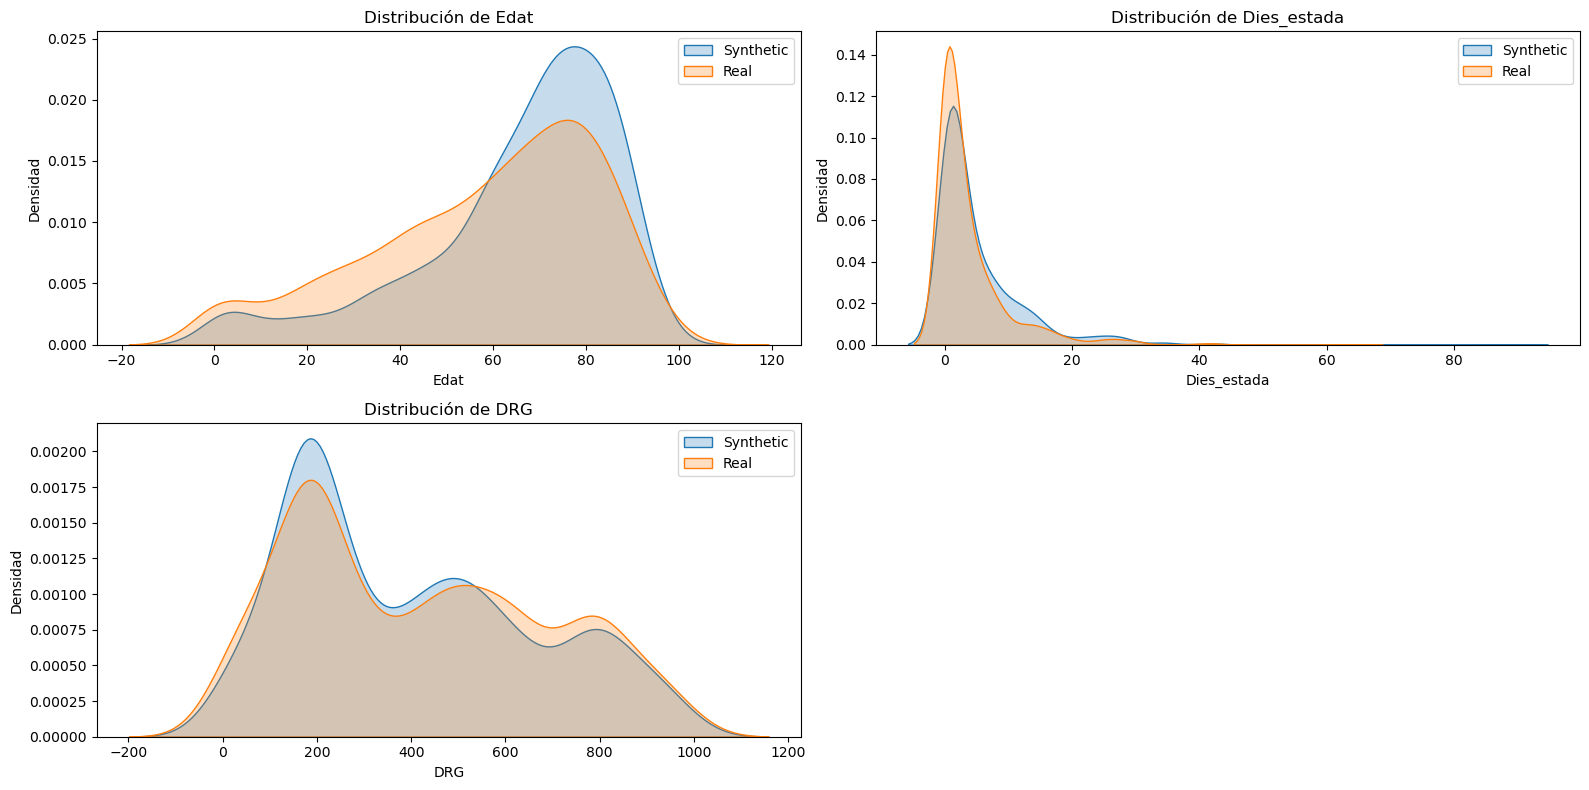

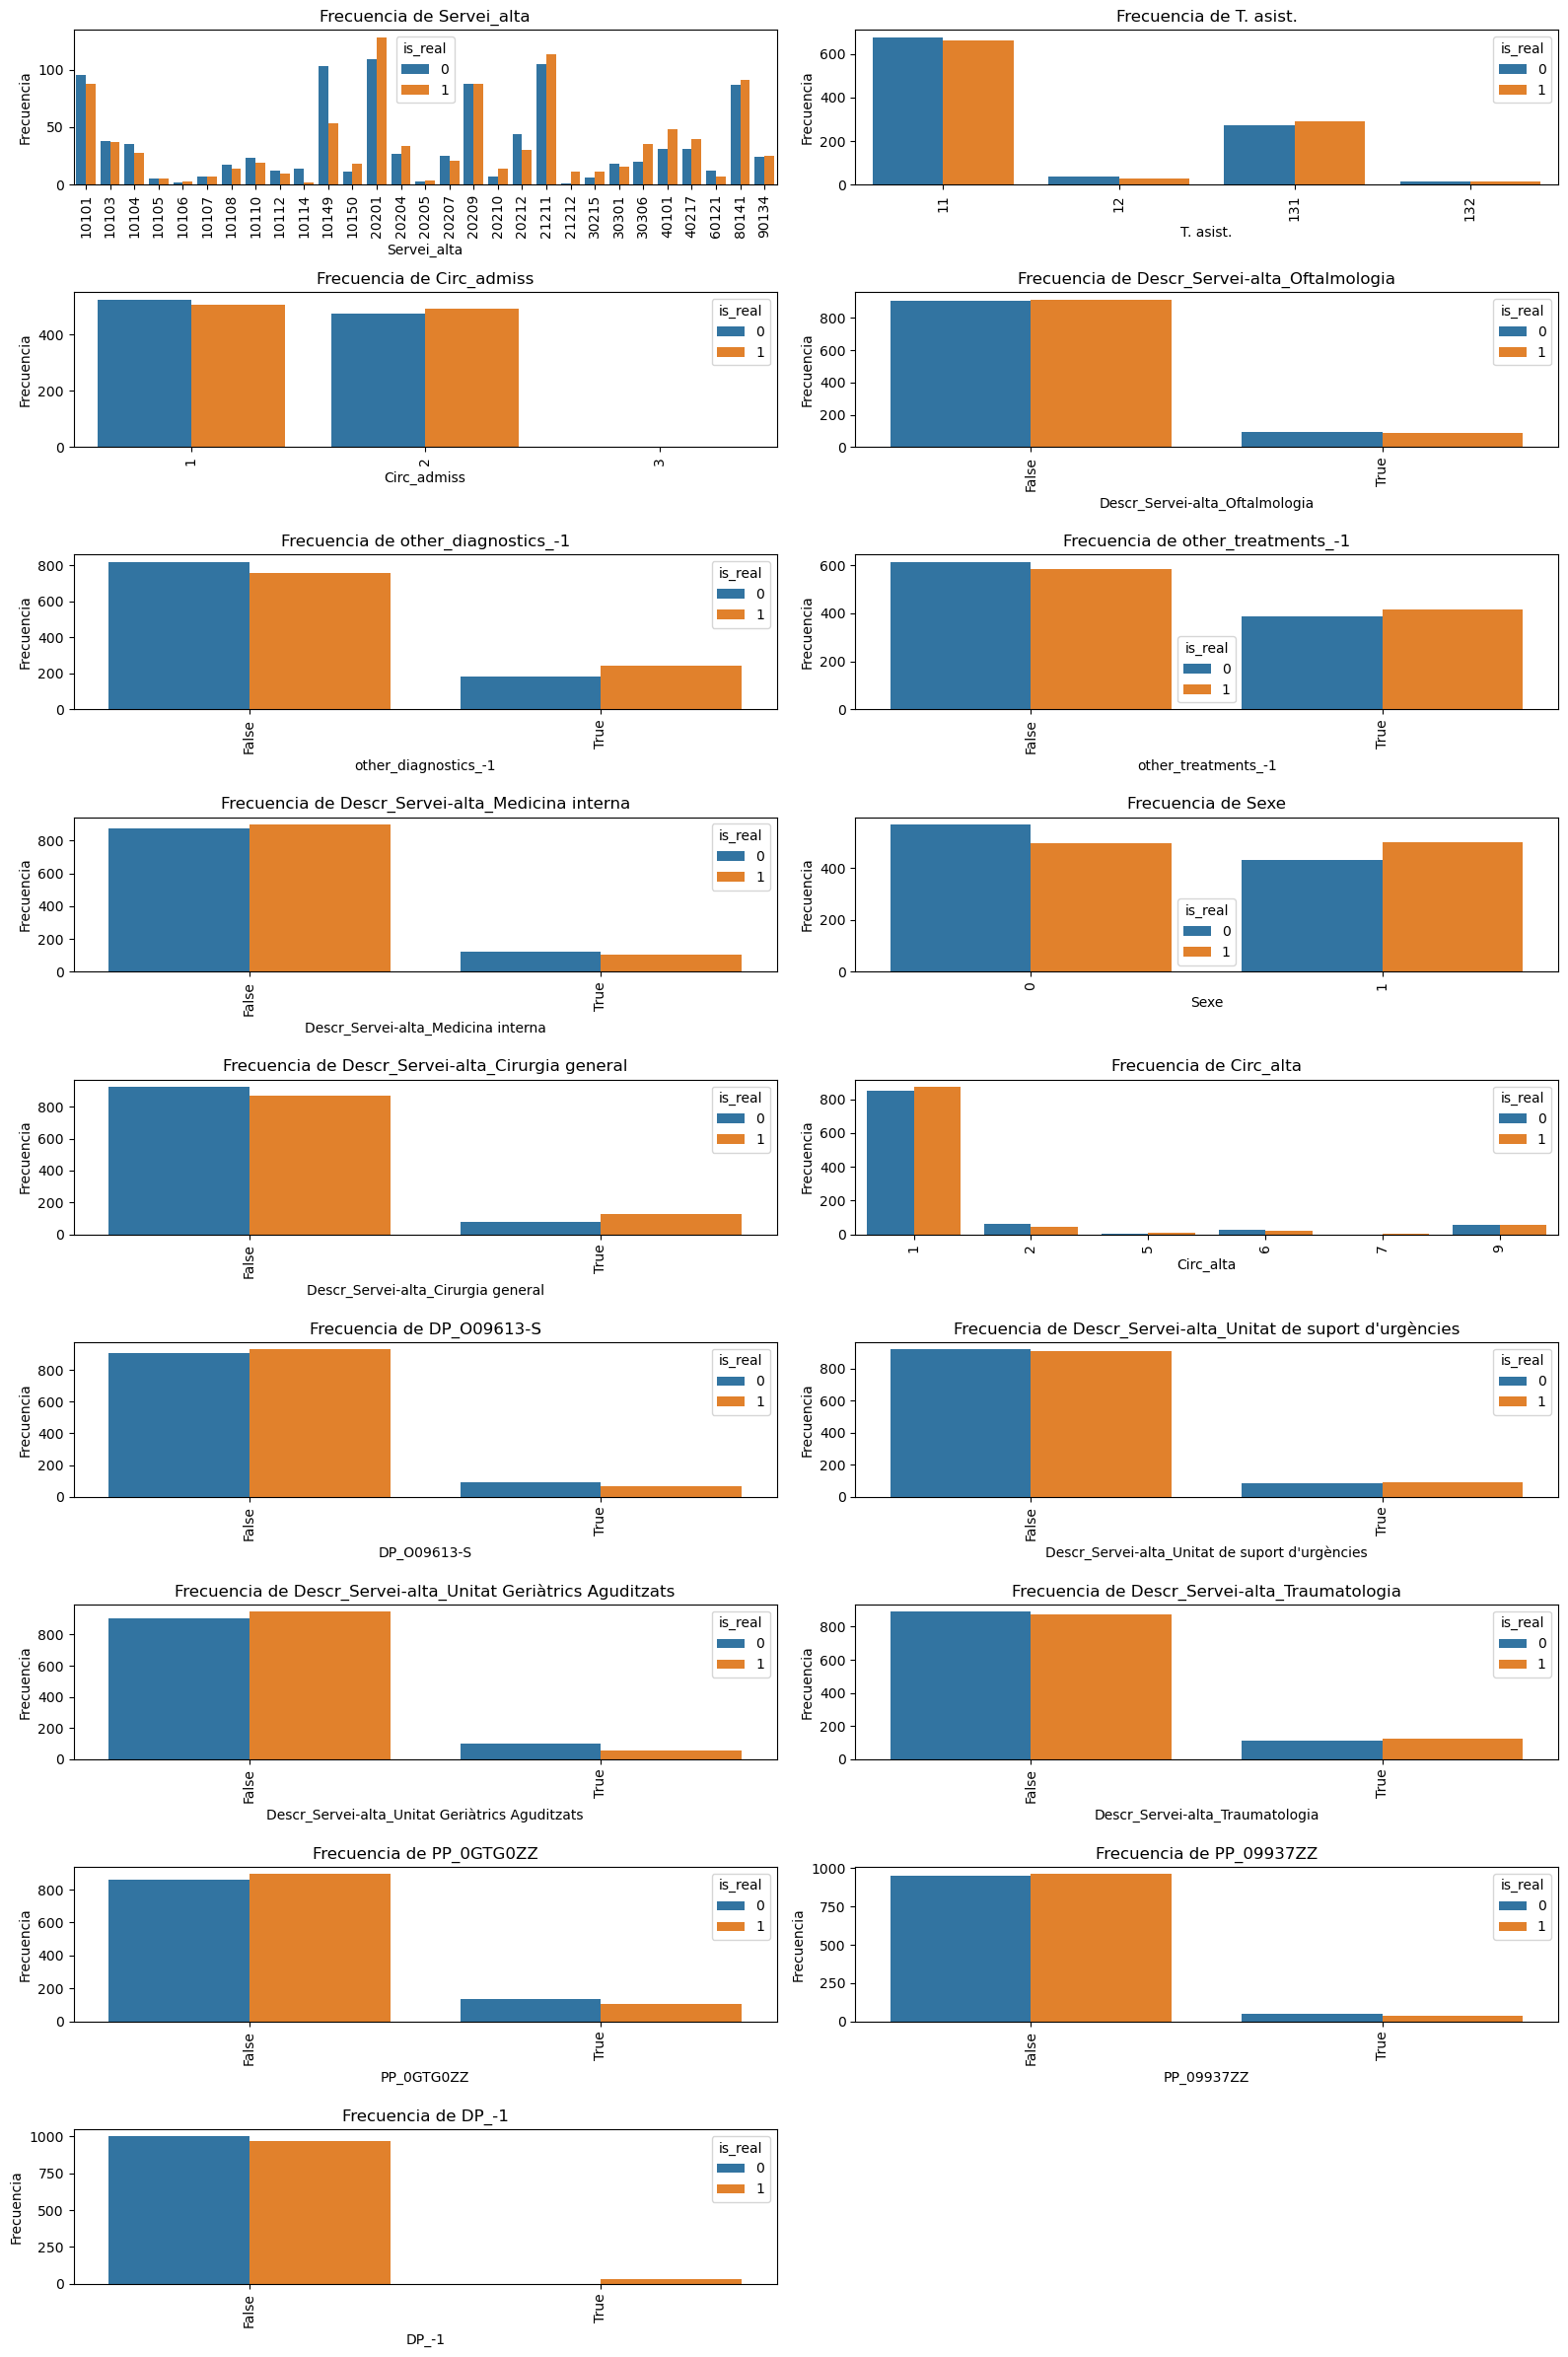

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'results_df' contiene los resultados de los experimentos anteriores
# Paso 1: Identificar el modelo con las métricas más bajas de accuracy
worst_iteration = results_df.loc[results_df['accuracy'].idxmin()]
worst_frequency = worst_iteration['frequency']
worst_k = worst_iteration['k']
worst_n = worst_iteration['n']

print("Modelo con las métricas más bajas de accuracy:")
print(f"Frequency: {worst_frequency}, k: {worst_k}, n: {worst_n}")
print(f"Accuracy: {worst_iteration['accuracy']}, F1-Score: {worst_iteration['f1_score']}")

# Formatear las variables para que coincidan con los nombres de los archivos
worst_k_int = int(worst_k)
worst_n_int = int(worst_n)
worst_frequency_str = f"{worst_frequency:.4f}"  # Ajusta el número de decimales según sea necesario

# Asegurarse de que el string de frecuencia coincida con el formato del nombre del archivo
# Por ejemplo, si los archivos usan 'freq0.0005', entonces usar 4 decimales
worst_frequency_str = worst_frequency_str.rstrip('0').rstrip('.')  # Eliminar ceros y punto sobrantes

# Construir el nombre del archivo con los valores formateados
filename_episodes = f'episodios_sinteticos_k{worst_k_int}_n{worst_n_int}_freq{worst_frequency_str}.csv'

# Paso 2: Cargar los episodios sintéticos correspondientes
df_episodes = pd.read_csv(filename_episodes, sep=';')

# Cargar los datos reales agrupados con el mismo 'k'
filename_cluster = f'data_cluster_k{worst_k_int}.csv'
df_cluster = pd.read_csv(filename_cluster, sep=';')

# Continuar con el resto del código...
# Paso 3: Preparar los datos
# Muestra de datos
synthetic_sample = df_episodes.sample(n=1000, random_state=47).copy()
synthetic_sample['source'] = 'synthetic'
real_sample = df_cluster.sample(n=1000, random_state=49).copy()
real_sample['source'] = 'real'

# Mantener solo las columnas comunes
common_columns = synthetic_sample.columns.intersection(real_sample.columns)
synthetic_sample = synthetic_sample[common_columns]
real_sample = real_sample[common_columns]

# Procesar columnas de diagnósticos y tratamientos
diagnosis_columns = [f'DS{i}' for i in range(1, 15)]
treatment_columns = [f'PS{i}' for i in range(1, 15)]

synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(
    lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(
    lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(
    lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_treatments'] = real_sample[treatment_columns].apply(
    lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

# Eliminar columnas innecesarias
synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

# Eliminar columnas POA si están presentes
poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

# Combinar los datos
combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)
combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

# Eliminar columnas adicionales innecesarias
combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')
combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

# Manejar valores faltantes
combined_data.fillna(-1, inplace=True)

# Codificación one-hot
encoded_data = pd.get_dummies(combined_data)

# Paso 4: Entrenar el modelo Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Preparar características y objetivo
X_eval = encoded_data.drop(columns=['is_real'])
y_eval = encoded_data['is_real']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=0.3, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

# Extraer importancias de las características
importances = model.feature_importances_
feature_names = X_eval.columns
feature_importance = pd.DataFrame({'Característica': feature_names, 'Importancia': importances})
feature_importance.sort_values(by='Importancia', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)

# Paso 5: Generar los gráficos utilizando tu código
# Asegurar que las variables categóricas sean strings para Seaborn
encoded_data_plot = encoded_data.copy()
encoded_data_plot['is_real'] = encoded_data_plot['is_real'].astype(str)

# Tomar las 20 características más importantes
top_important_columns = feature_importance.head(20)['Característica'].tolist()

# Identificar variables continuas
continuous_vars = ['Edat', 'Dies_estada', 'DRG']
continuous_vars = [var for var in continuous_vars if var in encoded_data_plot.columns]

# Variables categóricas son las más importantes excluyendo las continuas
categorical_vars = [col for col in top_important_columns if col not in continuous_vars]

# Filtrar el conjunto de datos solo con las columnas importantes
filtered_data = encoded_data_plot[top_important_columns + ['is_real']]

# Graficar variables continuas
if len(continuous_vars) > 0:
    # Crear subplots para variables continuas
    fig, axes = plt.subplots(nrows=(len(continuous_vars) + 1) // 2, ncols=2, figsize=(16, 8))
    axes = axes.flatten()
    for i, var in enumerate(continuous_vars):
        if var in filtered_data.columns:
            sns.kdeplot(data=filtered_data[filtered_data['is_real'] == '0'], x=var, ax=axes[i], label='Synthetic', shade=True)
            sns.kdeplot(data=filtered_data[filtered_data['is_real'] == '1'], x=var, ax=axes[i], label='Real', shade=True)
            axes[i].set_title(f'Distribución de {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Densidad')
            axes[i].legend()
    # Eliminar ejes no utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables continuas para graficar.")

# Graficar variables categóricas
if len(categorical_vars) > 0:
    # Crear subplots para variables categóricas
    fig, axes = plt.subplots(nrows=(len(categorical_vars) + 1) // 2, ncols=2, figsize=(16, 24))
    axes = axes.flatten()
    for i, var in enumerate(categorical_vars):
        if var in filtered_data.columns:
            sns.countplot(data=filtered_data, x=var, hue='is_real', ax=axes[i])
            axes[i].set_title(f'Frecuencia de {var}')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frecuencia')
    # Eliminar ejes no utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables categóricas para graficar.")
